OCT IMAGE CLASSIFICATION PROJECT - NOTEBOOK 1: DATA SETUP & EDA

[1/6] Setting up data directories...
✓ Data directory: /kaggle/input/oct2017/OCT2017
✓ Output directory: /kaggle/working
✓ EDA output directory: /kaggle/working/eda_results

[2/6] Exploring dataset structure...
OCT2017/ (0 files)
  val/ (0 files)
    DRUSEN/ (8 files)
    CNV/ (8 files)
    NORMAL/ (8 files)
    DME/ (8 files)
  test/ (0 files)
    DRUSEN/ (242 files)
    CNV/ (242 files)
    NORMAL/ (242 files)
    DME/ (242 files)
  train/ (0 files)
    DRUSEN/ (8616 files)
    CNV/ (37205 files)
    NORMAL/ (26315 files)
    DME/ (11348 files)

[3/6] Counting images per class...

DATASET SUMMARY
Split   test  train  val
Class                   
CNV      242  37205    8
DME      242  11348    8
DRUSEN   242   8616    8
NORMAL   242  26315    8

Total images: 84484
✓ Saved dataset summary to /kaggle/working/eda_results/dataset_summary.csv

[4/6] Creating class distribution visualizations...
✓ Saved class distribution plo

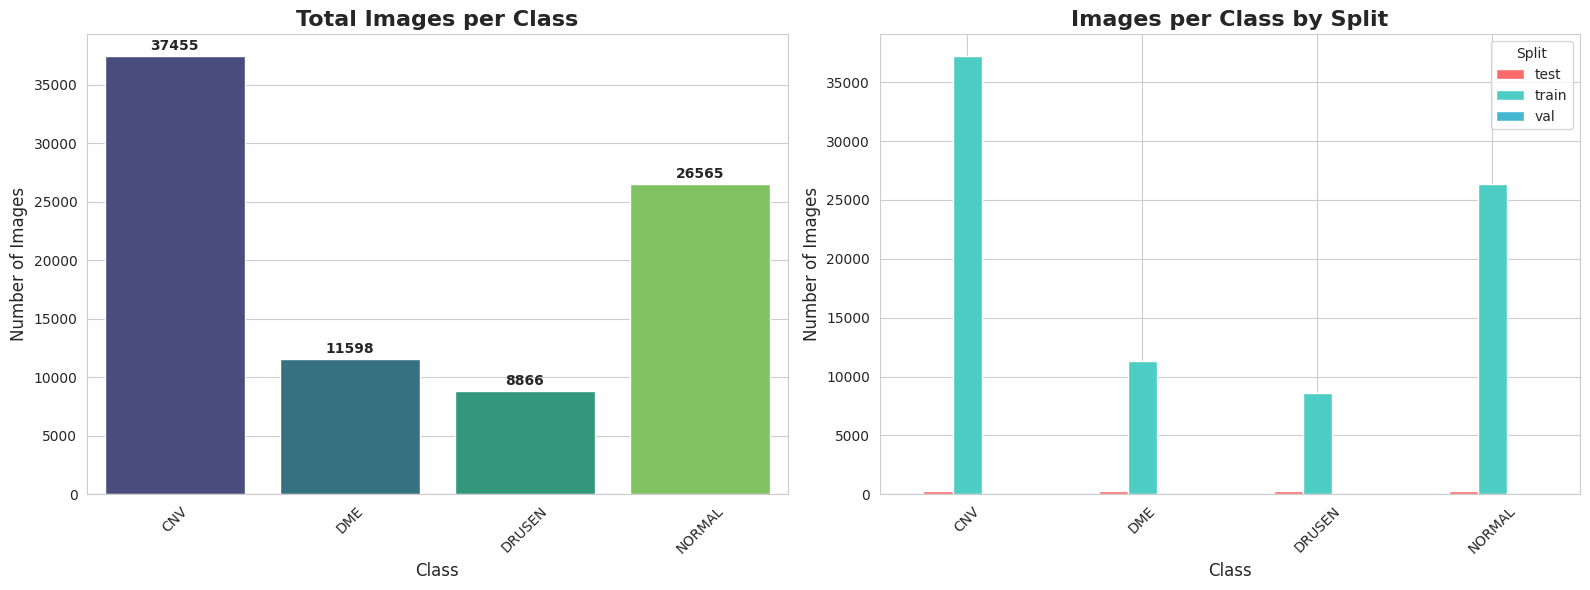


[5/6] Visualizing sample images from each class...
✓ Saved sample images to /kaggle/working/eda_results/sample_images.png


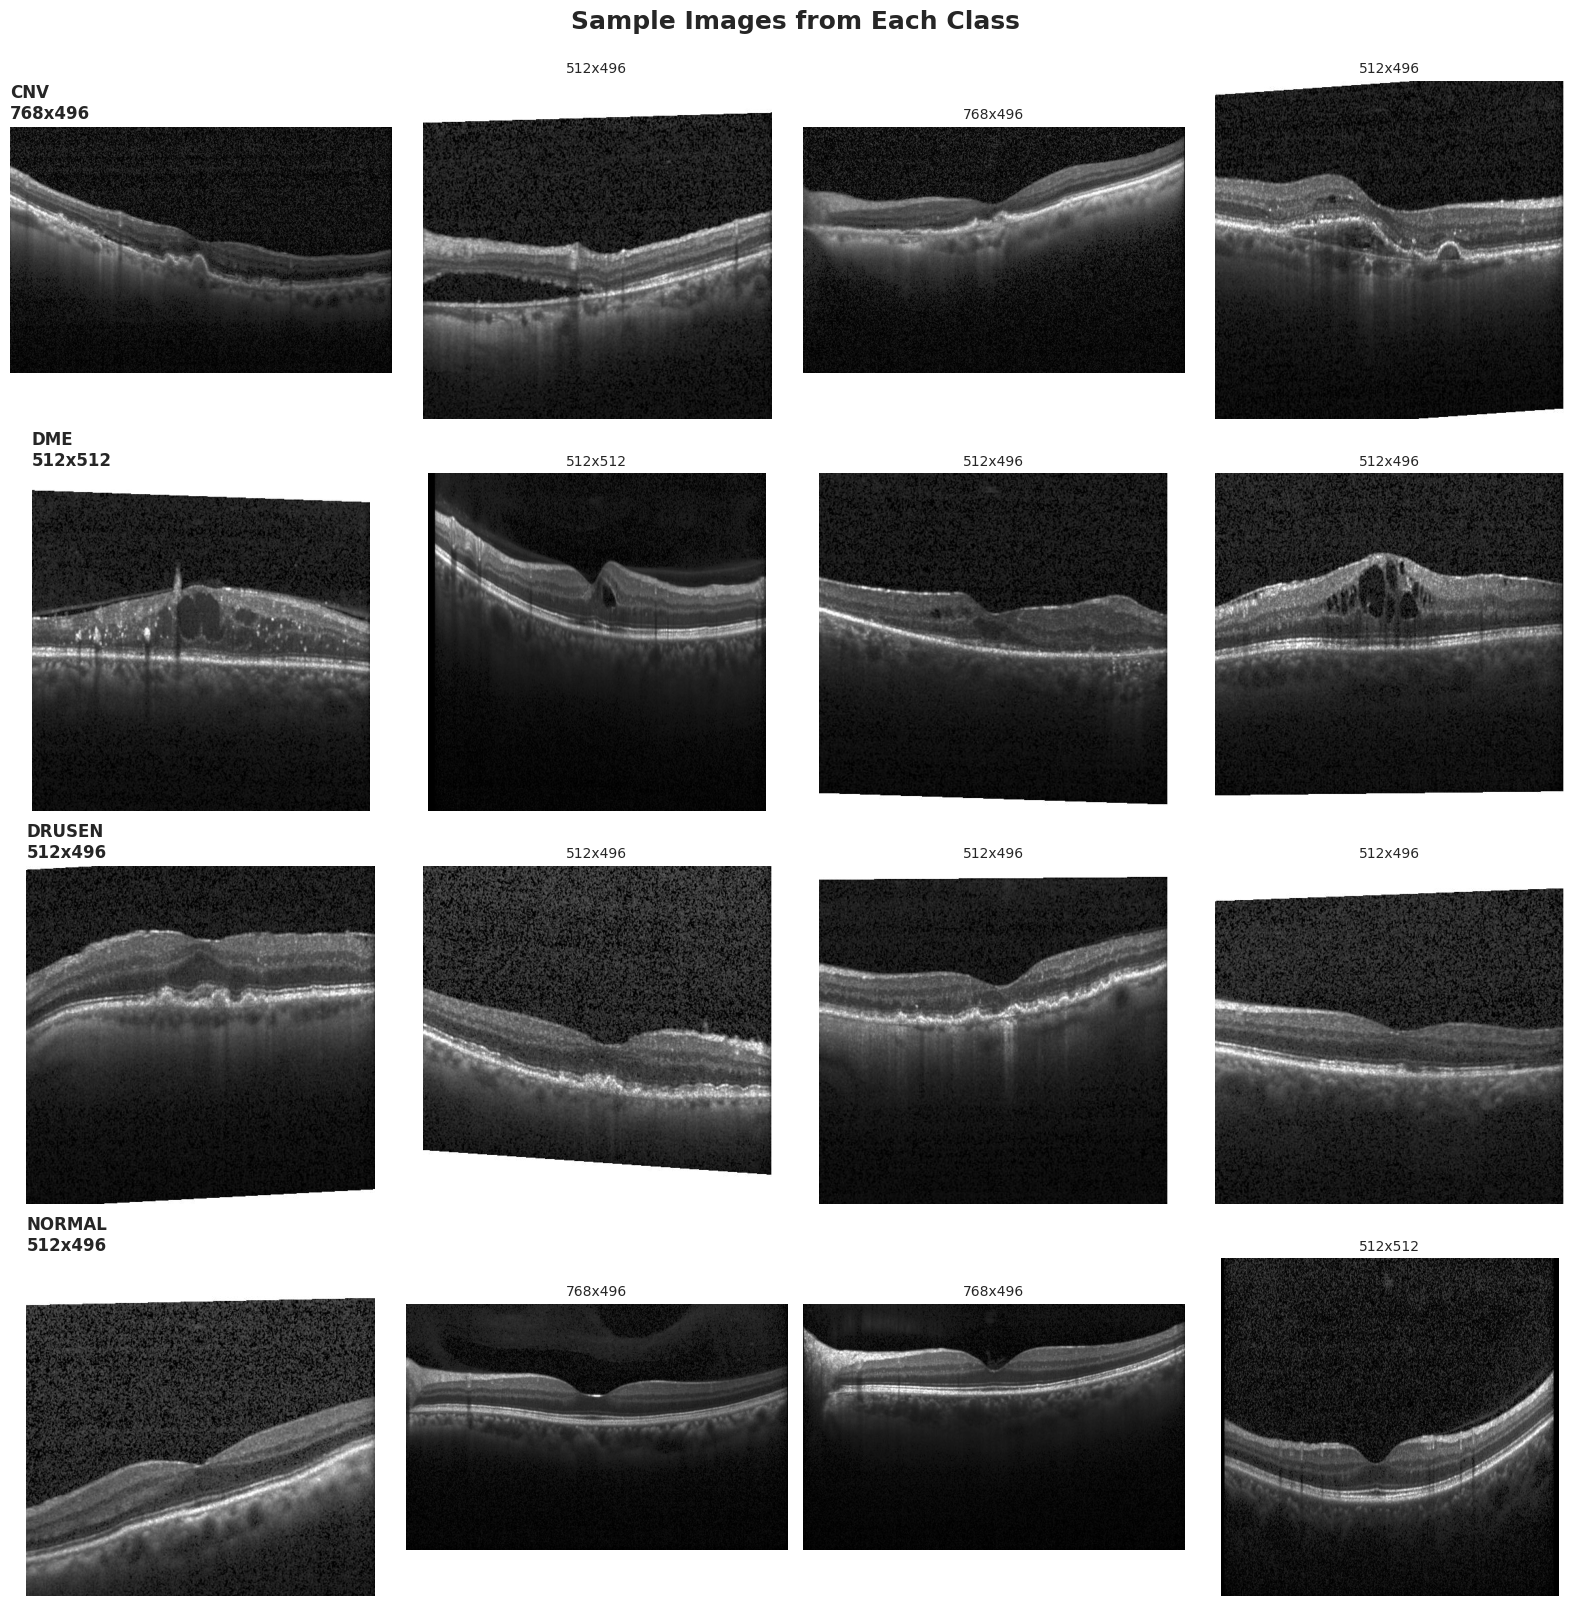


[6/6] Analyzing image statistics (dimensions, aspect ratios)...

IMAGE STATISTICS SUMMARY
        Width                                                          Height  \
        count     mean         std    min    25%    50%    75%     max  count   
Class                                                                           
CNV     500.0  716.800  326.965473  512.0  512.0  512.0  768.0  1536.0  500.0   
DME     500.0  573.952  205.554682  512.0  512.0  512.0  512.0  1536.0  500.0   
DRUSEN  500.0  660.992  275.434013  512.0  512.0  512.0  768.0  1536.0  500.0   
NORMAL  500.0  664.576  295.394150  512.0  512.0  512.0  768.0  1536.0  500.0   

                 ... Aspect_Ratio           Total_Pixels              \
           mean  ...          75%       max        count        mean   
Class            ...                                                   
CNV     496.000  ...     1.548387  3.096774        500.0  355532.800   
DME     508.128  ...     1.000000  3.096774        50

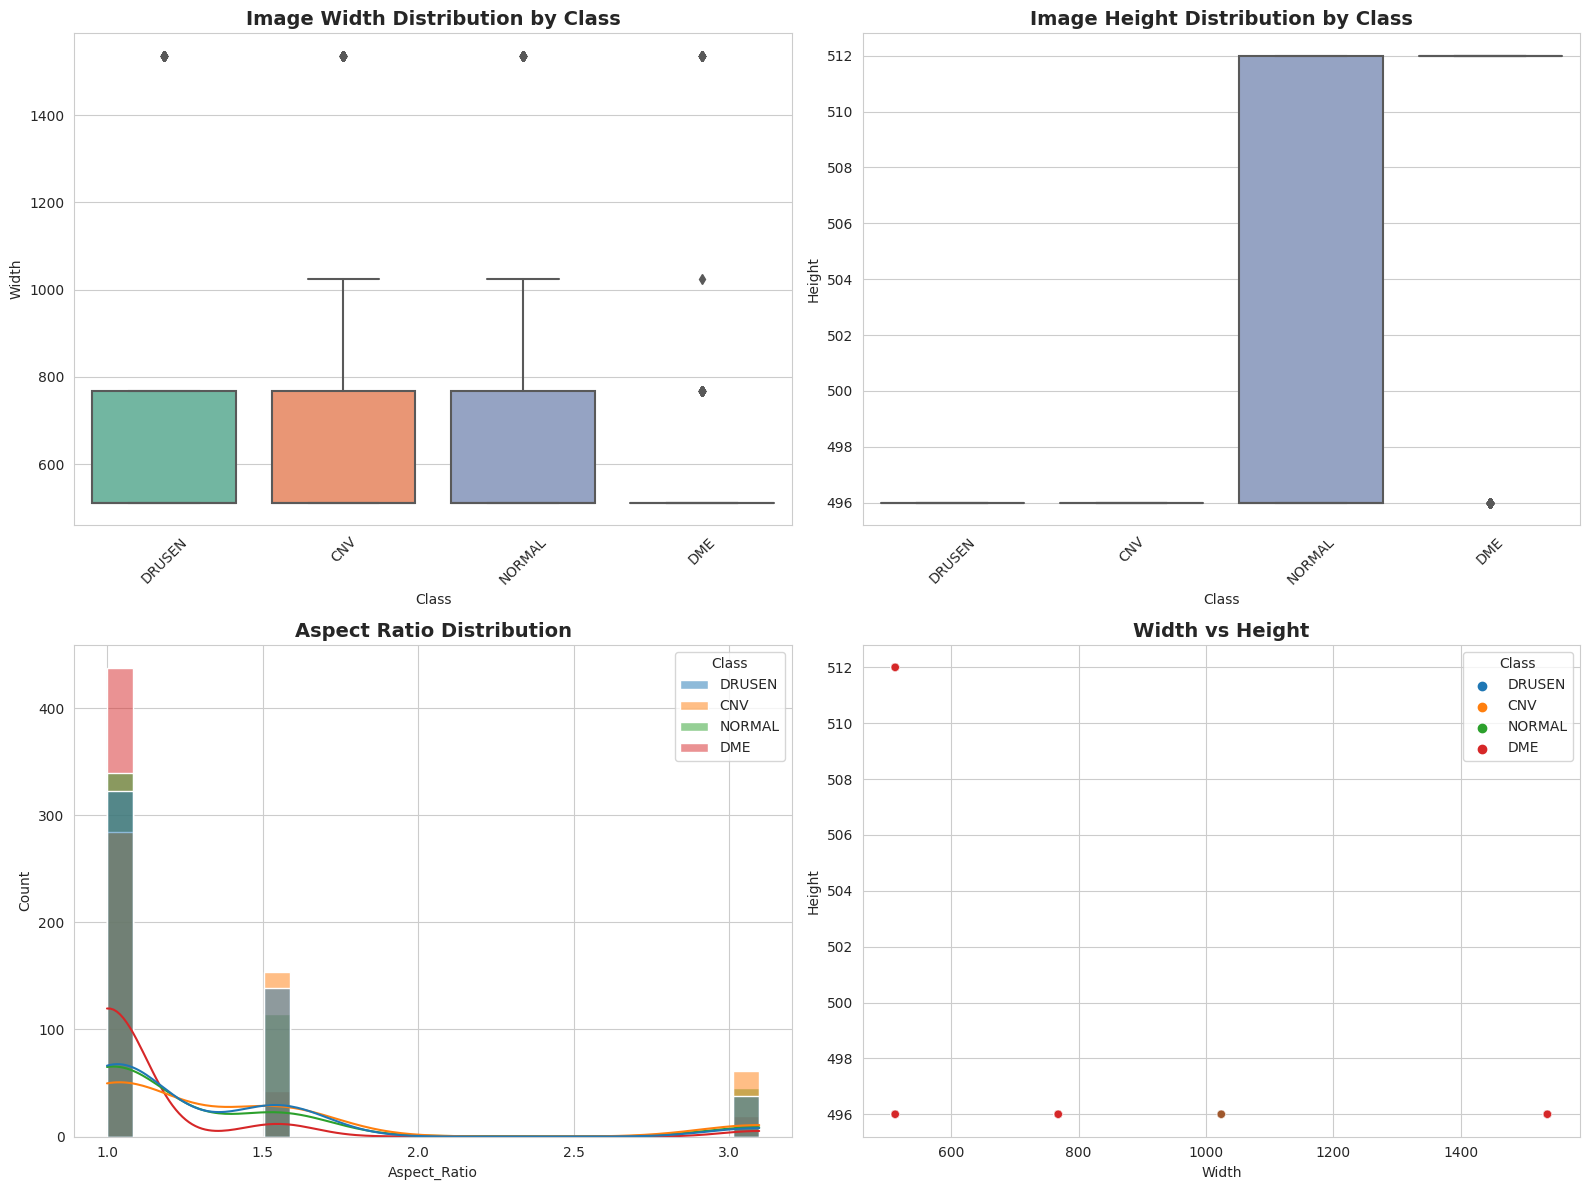


NOTEBOOK 1 COMPLETED SUCCESSFULLY!

✓ All EDA outputs saved to: /kaggle/working/eda_results

Generated files:
  1. dataset_summary.csv
  2. class_distribution.png
  3. sample_images.png
  4. image_statistics.csv
  5. image_statistics.png

📌 NEXT STEP: Run Notebook 2 for Segmentation Preprocessing


In [10]:
# ============================================================================
# NOTEBOOK 1: DATA SETUP AND EXPLORATORY DATA ANALYSIS
# ============================================================================
# This notebook downloads data, performs EDA, and saves analysis results
# GPU: NOT REQUIRED (runs on CPU)
# Output: EDA visualizations, class distribution stats, sample images
# ============================================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import shutil
from pathlib import Path
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

print("="*80)
print("OCT IMAGE CLASSIFICATION PROJECT - NOTEBOOK 1: DATA SETUP & EDA")
print("="*80)

# ============================================================================
# 1. DOWNLOAD AND ORGANIZE DATASET
# ============================================================================
print("\n[1/6] Setting up data directories...")

# Kaggle dataset path (when you add the dataset to your notebook)
DATA_DIR = '/kaggle/input/oct2017/OCT2017'
OUTPUT_DIR = '/kaggle/working'
EDA_OUTPUT = os.path.join(OUTPUT_DIR, 'eda_results')
os.makedirs(EDA_OUTPUT, exist_ok=True)

print(f"✓ Data directory: {DATA_DIR}")
print(f"✓ Output directory: {OUTPUT_DIR}")
print(f"✓ EDA output directory: {EDA_OUTPUT}")

# ============================================================================
# 2. EXPLORE DIRECTORY STRUCTURE
# ============================================================================
print("\n[2/6] Exploring dataset structure...")

def explore_directory(path, max_depth=3):
    """Recursively explore directory structure"""
    structure = {}
    for root, dirs, files in os.walk(path):
        level = root.replace(path, '').count(os.sep)
        if level < max_depth:
            indent = ' ' * 2 * level
            folder_name = os.path.basename(root)
            print(f'{indent}{folder_name}/ ({len(files)} files)')
            structure[root] = len(files)
    return structure

dir_structure = explore_directory(DATA_DIR, max_depth=4)

# ============================================================================
# 3. COUNT IMAGES PER CLASS
# ============================================================================
print("\n[3/6] Counting images per class...")

def count_images_in_dataset(base_path):
    """Count images in train/test/val splits"""
    data_info = {}
    
    for split in ['train', 'test', 'val']:
        split_path = os.path.join(base_path, split)
        if not os.path.exists(split_path):
            continue
            
        data_info[split] = {}
        classes = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]
        
        for cls in classes:
            cls_path = os.path.join(split_path, cls)
            images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            data_info[split][cls] = len(images)
    
    return data_info

# Count all images
dataset_info = count_images_in_dataset(DATA_DIR)

# Create summary DataFrame
summary_data = []
for split, classes in dataset_info.items():
    for cls, count in classes.items():
        summary_data.append({'Split': split, 'Class': cls, 'Count': count})

df_summary = pd.DataFrame(summary_data)
print("\n" + "="*60)
print("DATASET SUMMARY")
print("="*60)
print(df_summary.pivot(index='Class', columns='Split', values='Count').fillna(0).astype(int))
print(f"\nTotal images: {df_summary['Count'].sum()}")

# Save summary
df_summary.to_csv(os.path.join(EDA_OUTPUT, 'dataset_summary.csv'), index=False)
print(f"✓ Saved dataset summary to {EDA_OUTPUT}/dataset_summary.csv")

# ============================================================================
# 4. VISUALIZE CLASS DISTRIBUTION
# ============================================================================
print("\n[4/6] Creating class distribution visualizations...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Overall distribution
df_total = df_summary.groupby('Class')['Count'].sum().reset_index()
sns.barplot(data=df_total, x='Class', y='Count', palette='viridis', ax=axes[0])
axes[0].set_title('Total Images per Class', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_ylabel('Number of Images', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(df_total['Count']):
    axes[0].text(i, v + 500, str(v), ha='center', fontweight='bold')

# Plot 2: Split-wise distribution
pivot_df = df_summary.pivot(index='Class', columns='Split', values='Count').fillna(0)
pivot_df.plot(kind='bar', ax=axes[1], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1].set_title('Images per Class by Split', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Class', fontsize=12)
axes[1].set_ylabel('Number of Images', fontsize=12)
axes[1].legend(title='Split', fontsize=10)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(EDA_OUTPUT, 'class_distribution.png'), dpi=300, bbox_inches='tight')
print(f"✓ Saved class distribution plot to {EDA_OUTPUT}/class_distribution.png")
plt.show()

# ============================================================================
# 5. SAMPLE IMAGE VISUALIZATION
# ============================================================================
print("\n[5/6] Visualizing sample images from each class...")

def get_sample_images(base_path, split='train', samples_per_class=3):
    """Get sample images from each class"""
    split_path = os.path.join(base_path, split)
    classes = sorted([d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))])
    
    samples = {}
    for cls in classes:
        cls_path = os.path.join(split_path, cls)
        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        samples[cls] = [os.path.join(cls_path, img) for img in images[:samples_per_class]]
    
    return samples

# Get samples
sample_images = get_sample_images(DATA_DIR, split='train', samples_per_class=4)
num_classes = len(sample_images)
samples_per_class = 4

# Create visualization
fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(16, 4*num_classes))
fig.suptitle('Sample Images from Each Class', fontsize=18, fontweight='bold', y=1.001)

for idx, (cls, img_paths) in enumerate(sample_images.items()):
    for jdx, img_path in enumerate(img_paths):
        img = Image.open(img_path)
        if num_classes == 1:
            ax = axes[jdx]
        else:
            ax = axes[idx, jdx]
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        if jdx == 0:
            ax.set_title(f'{cls}\n{img.size[0]}x{img.size[1]}', 
                        fontsize=12, fontweight='bold', loc='left')
        else:
            ax.set_title(f'{img.size[0]}x{img.size[1]}', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(EDA_OUTPUT, 'sample_images.png'), dpi=300, bbox_inches='tight')
print(f"✓ Saved sample images to {EDA_OUTPUT}/sample_images.png")
plt.show()

# ============================================================================
# 6. IMAGE STATISTICS ANALYSIS
# ============================================================================
print("\n[6/6] Analyzing image statistics (dimensions, aspect ratios)...")

def analyze_image_stats(base_path, split='train', sample_size=500):
    """Analyze image dimensions and statistics"""
    split_path = os.path.join(base_path, split)
    classes = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]
    
    stats = []
    for cls in classes:
        cls_path = os.path.join(split_path, cls)
        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Sample images for efficiency
        sampled = np.random.choice(images, min(sample_size, len(images)), replace=False)
        
        for img_name in sampled:
            img_path = os.path.join(cls_path, img_name)
            img = Image.open(img_path)
            width, height = img.size
            stats.append({
                'Class': cls,
                'Width': width,
                'Height': height,
                'Aspect_Ratio': width/height,
                'Total_Pixels': width*height
            })
    
    return pd.DataFrame(stats)

# Analyze
df_stats = analyze_image_stats(DATA_DIR, split='train', sample_size=500)

print("\n" + "="*60)
print("IMAGE STATISTICS SUMMARY")
print("="*60)
print(df_stats.groupby('Class')[['Width', 'Height', 'Aspect_Ratio', 'Total_Pixels']].describe())

# Save stats
df_stats.to_csv(os.path.join(EDA_OUTPUT, 'image_statistics.csv'), index=False)
print(f"\n✓ Saved image statistics to {EDA_OUTPUT}/image_statistics.csv")

# Visualize distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.boxplot(data=df_stats, x='Class', y='Width', palette='Set2', ax=axes[0, 0])
axes[0, 0].set_title('Image Width Distribution by Class', fontsize=14, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)

sns.boxplot(data=df_stats, x='Class', y='Height', palette='Set2', ax=axes[0, 1])
axes[0, 1].set_title('Image Height Distribution by Class', fontsize=14, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)

sns.histplot(data=df_stats, x='Aspect_Ratio', hue='Class', kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Aspect Ratio Distribution', fontsize=14, fontweight='bold')

sns.scatterplot(data=df_stats, x='Width', y='Height', hue='Class', alpha=0.6, ax=axes[1, 1])
axes[1, 1].set_title('Width vs Height', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(EDA_OUTPUT, 'image_statistics.png'), dpi=300, bbox_inches='tight')
print(f"✓ Saved image statistics plots to {EDA_OUTPUT}/image_statistics.png")
plt.show()

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("NOTEBOOK 1 COMPLETED SUCCESSFULLY!")
print("="*80)
print(f"\n✓ All EDA outputs saved to: {EDA_OUTPUT}")
print("\nGenerated files:")
print("  1. dataset_summary.csv")
print("  2. class_distribution.png")
print("  3. sample_images.png")
print("  4. image_statistics.csv")
print("  5. image_statistics.png")
print("\n📌 NEXT STEP: Run Notebook 2 for Segmentation Preprocessing")
print("="*80)
